## Modellisation du problème

Dans le cadre de l'étude de l'évolution d'une pandémie comme celle du Covic-19, nous utilisons une représentation de l'état basée sur le modèle SEIR défini dans le papier [Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/action/showPdf?pii=S0140-6736%2820%2930260-9).

Ce modèle présente un état sous forme de 4-uplet avec les éléments :
- S : Le nombre de personnes de la population susceptibles d'être atteintes par la maladie.
- E : Le nombre de personnes exposées par la maladie, qui en sont porteurs mais qui n'ont pas encore les symptômes.
- I : Le nombre de personnes infectées par la maladie, qui sont susceptible de la transmettre.
- R : Le nombre de persones rétablies, que l'on considère immunisées par la maladie. Celà peut dépendre aussi de la vaccination.

Le modèle SIR existe aussi mais nous avons voulu ajouter l'état E car une transmission non immédiate nous semble plus pertinente suite à l'expérience du Covid-19 qui pouvait montrer des périodes d'incubation jusqu'à une semaine. Nous pourrions aussi ajouter une évolution de la taille de la population par exemple suite à des décès dûes à l'infection, mais en première approximation, nous ne prendront pas en compte cette possibilité.

Nous nous inspirons du projet cité précédemment, où nous ne prenons pas en compte les voyageurs (L dans le papier) et l'infection animale z.

Les équations régissant notre problème deviennent :
$$\begin{aligned}
dS &= \left[ -\beta (1 - u_{conf}) \frac{S I}{N} - u_{vacc} S \right] dt + \sigma_S dW_t \\
dE &= \left[ \beta (1 - u_{conf}) \frac{S I}{N} - \sigma E \right] dt + \sigma_E dW_t \\
dI &= \left[ \sigma E - \gamma I \right] dt + \sigma_I dW_t \\
dR &= \left[ \gamma I + u_{vacc} S \right] dt + \sigma_R dW_t
\end{aligned}$$

où 
- $\beta$ (Taux de transmission sans confinement).
- $\sigma$ (Taux d'incubation) : 1/ temps d'incubation
- $\gamma$ (Taux de guérison) : 1/ temps de guérison
- $R_0$ (Taux de reproduction de base) : $\beta / \gamma$.

Notre contrôle, ce sur quoi nous avons un impact est :
- $u_{conf}$ : le niveau de confinement entre 0 et 1. 0 correspond au fonctionnement normal et 1 à un confinement total de la population. Nous le confondons avec le niveau d'intention proposé dans le sujet.
- $u_{vacc}$ : le taux de vaccination entre 0 et 1. Celà permet de considérer une partie de la population S comme rétablie (R).

## Références :
- [Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/action/showPdf?pii=S0140-6736%2820%2930260-9)
- [Reinforcement learning-based decision support system for COVID-19](https://www-sciencedirect-com.bases-doc.univ-lorraine.fr/science/article/pii/S1746809421002731)

---------------------------
## Implementation

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from model import SEIREnv, ProblemConfig


Tout d'abord, nous instancions les paramètres de notre modèle. Les valeurs choisies suivent l'article publié dans The Lancet.
Dans leur étude, ils indiquent un taux de reproduction de base $R_0$ estimé à $2,68$. Nous proposons $2,7$ pour la suite. Puisque cette valeur correspond à $\beta / \gamma$, nous proposons un temps de guérison de la maladie de 10 jours (ce qui correspond à peu prêt à notre propre expérience du confinement). 

In [ ]:
configs = ProblemConfig(
    beta=0.3,
    sigma=0.1,
    gamma=0.05,
    dt=1.0,
)


In [ ]:

# On instancie l'environnement
env = SEIREnv()

# Vérification rapide que l'environnement respecte les standards Gym
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)
print("Environnement validé !")


Environnement validé !


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/home/csutty/miniconda3/envs/rlearning/lib/python3.13/site-packages/stable_baselines3/common/env_checker.py:507: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [3]:
# Définition du modèle PPO
# MlpPolicy = Réseau de neurones classique (Multi Layer Perceptron)
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, gamma=0.99)

print("Début de l'entraînement...")
# 50 000 timesteps devraient suffire pour voir une convergence sur ce problème simple
model.learn(total_timesteps=50000)
print("Entraînement terminé.")

# Sauvegarde du modèle (pour le rapport)
model.save("ppo_seir_covid")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/csutty/miniconda3/envs/rlearning/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Début de l'entraînement...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.4     |
|    ep_rew_mean     | -5.62    |
| time/              |          |
|    fps             | 675      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.3        |
|    ep_rew_mean          | -4.9        |
| time/                   |             |
|    fps                  | 524         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008165791 |
|    clip_fraction        | 0.0546      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0047      |
|  

In [4]:
def run_simulation(env, model=None):
    """
    Lance une simulation.
    Si model est None, on ne fait rien (Laissez-faire).
    Sinon, on utilise l'agent entraîné.
    """
    obs, _ = env.reset()
    done = False

    history = {"S": [], "E": [], "I": [], "R": [], "Conf": [], "Vacc": [], "Reward": []}

    while not done:
        if model:
            action, _ = model.predict(obs, deterministic=True)
        else:
            action = [0.0, 0.0]  # Aucune action (Laissez-faire)

        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Enregistrement pour les graphes
        history["S"].append(obs[0])
        history["E"].append(obs[1])
        history["I"].append(obs[2])
        history["R"].append(obs[3])

        if model:
            history["Conf"].append(action[0])
            history["Vacc"].append(action[1])
        else:
            history["Conf"].append(0)
            history["Vacc"].append(0)

        history["Reward"].append(reward)

    return history


# Lancer les deux scénarios
env_eval = SEIREnv()
history_rl = run_simulation(env_eval, model)
history_no_action = run_simulation(env_eval, model=None)


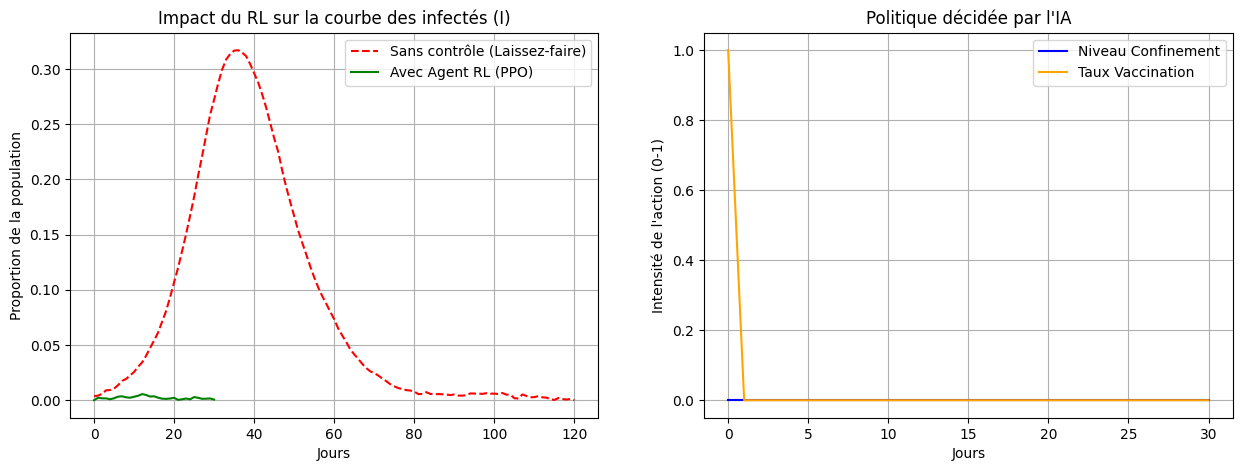

In [5]:
# Création des graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1 : Comparaison des Infectés (Courbe épidémique)
ax1.plot(
    history_no_action["I"],
    label="Sans contrôle (Laissez-faire)",
    linestyle="--",
    color="red",
)
ax1.plot(history_rl["I"], label="Avec Agent RL (PPO)", color="green")
ax1.set_title("Impact du RL sur la courbe des infectés (I)")
ax1.set_xlabel("Jours")
ax1.set_ylabel("Proportion de la population")
ax1.legend()
ax1.grid(True)

# Graphique 2 : Stratégie de l'Agent
ax2.plot(history_rl["Conf"], label="Niveau Confinement", color="blue")
ax2.plot(history_rl["Vacc"], label="Taux Vaccination", color="orange")
ax2.set_title("Politique décidée par l'IA")
ax2.set_xlabel("Jours")
ax2.set_ylabel("Intensité de l'action (0-1)")
ax2.legend()
ax2.grid(True)

plt.show()
